In [1]:
import orbipy as op
import numpy as np
import pandas as pd
from numba.core.ir import Raise
from numba.np.arrayobj import np_array
from orbipy import plotter
from orbipy.correction import border_correction, base_correction
from scipy.optimize import bisect
from matplotlib import pyplot as plt
import pickle


In [2]:
model = op.crtbp3_model('Earth-Moon (default)', integrator=op.dopri5_integrator(), stm=True)
one_thousand_kms = (1-model.L1) / 61.350

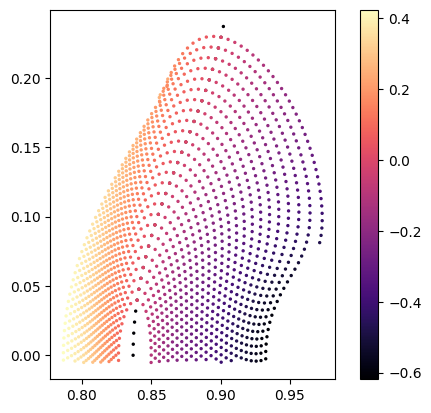

In [3]:

data_zvl = np.load('data/contour_points/zvl/zvl_2.npy')
data_zvl = np.c_[data_zvl, np.zeros(len(data_zvl))]

with open(r"data/contour_points/contour_points_data_5_points.pickle", "rb") as input_file:
    data = pickle.load(input_file)
data_points = []
for line in data:
    for point in line:
        data_points.append(point)
        
data_points = np.array(data_points)

# print(data_points)
plt.scatter(data_zvl[:32,0], data_zvl[:32,1], c=data_zvl[:32,2], cmap='magma', s=2)
plt.scatter(data_points[:,0], data_points[:,1], c=data_points[:,2], cmap='magma', s=2)

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()

In [5]:
class zero_correction(op.corrections.base_correction):
    def __init__(self, model, direction):
        super().__init__(model, direction)
        
    def calc_dv(self, t, s):
        return model.get_zero_state()
        

In [28]:
def generate_initial_state_map_with_sum_dv(model, data, output_data, n):
    def find_approximate_period(state):
        left = op.eventX(model.L1 - 33 * one_thousand_kms)
        right = op.eventX(model.L1 + 53 * one_thousand_kms)
        
        event = op.eventX(count=2, terminal=True)
        
        correction = op.border_correction(model, op.unstable_direction(model), [left], [right])
        first_correction = zero_correction(model, op.unstable_direction(model))
        impulse_correction = op.simple_station_keeping(model, first_correction, correction, rev=np.pi/4, events=[event])
        s0 = model.get_zero_state()
        
        s0[0] = state[0]
        s0[2] = state[1]
        s0[4] = state[2]
        try:
            df = impulse_correction.prop(0, s0, 20)
        except (RuntimeError, ValueError) as e:
            print(f"!xxxxxx! {state}, Exception: {e}")
            return np.pi
        time = impulse_correction.evout[-1][3]
        return time
    
    def impulse_correction_sum_dv(state, n):
        left = op.eventX(model.L1 - 33 * one_thousand_kms)
        right = op.eventX(model.L1 + 53 * one_thousand_kms)
        
        correction = op.border_correction(model, op.unstable_direction(model), [left], [right])
        first_correction = zero_correction(model, op.unstable_direction(model))
        impulse_correction = op.simple_station_keeping(model, first_correction, correction, rev=np.pi/4)
        s0 = model.get_zero_state()
        
        s0[0] = state[0]
        s0[2] = state[1]
        s0[4] = state[2]
        try:
            df = impulse_correction.prop(0, s0, n)
        except (RuntimeError, ValueError) as e:
            print(f"!xxxxxx! {state}, Exception: {e}")
            return -1
        dv_norms = np.linalg.norm(impulse_correction.dvout[:,3:6], axis=1)
        return np.sum(dv_norms)
    
    for line in data:
        line_output = []
        for initial_sate in line:
            print(initial_sate)
            period = find_approximate_period(initial_sate)
            print(period)
            sum_dv = impulse_correction_sum_dv(initial_sate, n*period)
            print(sum_dv)
            line_output.append([initial_sate, sum_dv])
        output_data.append(line_output)
        
        

In [29]:
output = []
generate_initial_state_map_with_sum_dv(model, [data[48]], output, 20)

[0.8984027046569313, 0.22156462361470391, 0.0]
Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


IndexError: list index out of range